<h1>! Work in progress!</h1>

**To Do:**

- Theoretical part explaining :
  - Image Generation task and various family of models.
  - Denoising Diffusion Probabilistic Models (DDPMs) (Forward and reverse processes).
- Add description of tasks to do.
- Hide cells that won't be used (model definition, training loop, util functions...).
- Setup Evaluation metric.

# ---------------------------------------------------
# Part 1: Understanding Diffusion Models
# ---------------------------------------------------

# Theory Section: Diffusion Models

1. What are diffusion models?

Diffusion models are generative models that learn to generate data by reversing a gradual noising process.
They work by slowly adding random noise to data in a forward process, and then learning to reverse this
process to recover the original data distribution. Unlike GANs or VAEs, diffusion models use a sequence
of denoising steps, making them more stable to train but potentially slower to sample from.

2. Forward diffusion process:

The forward diffusion process gradually adds Gaussian noise to an image over T timesteps according to a
predefined noise schedule. At each step t, some portion of the original signal is preserved while new noise
is added. As t increases, the image becomes more noisy until at t=T, it approaches a pure Gaussian noise
distribution. Mathematically, this is defined as q(x_t|x_{t-1}) where each step adds a small amount of
Gaussian noise according to variance β_t.

3. Reverse diffusion process (sampling):

The reverse diffusion process (sampling) starts with a pure noise sample x_T ~ N(0,1) and gradually denoises
it over T steps to generate a sample from the data distribution. At each step, the model predicts the noise
component in the current noisy image, then uses this prediction to compute a slightly less noisy image for
the next step. This process continues until we reach x_0, which should resemble a sample from the original
data distribution. In our case, we'll get fashion items like clothing and shoes.

4. What does the neural network in DDPM actually learn to predict?

The neural network in DDPM learns to predict the noise ε that was added to the image at a particular timestep t

# ---------------------------------------------------
# Part 2: Implementing DDPMs
# ---------------------------------------------------


In [ ]:
# DDPM Challenge: Generate Your Own Fashion Items

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torchvision.utils import make_grid

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# ---------------------------------------------------
# Part 2: Load and Visualize the MNIST Dataset
# ---------------------------------------------------

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),                # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (1.0,))  # Normalize to [-1, 1]
])

# Load Fashion MNIST dataset
train_dataset = FashionMNIST('./data', train=True, download=True, transform=transform)

# Fashion MNIST classes
fashion_mnist_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


100%|██████████| 26.4M/26.4M [00:02<00:00, 10.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 166kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.11MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 15.8MB/s]


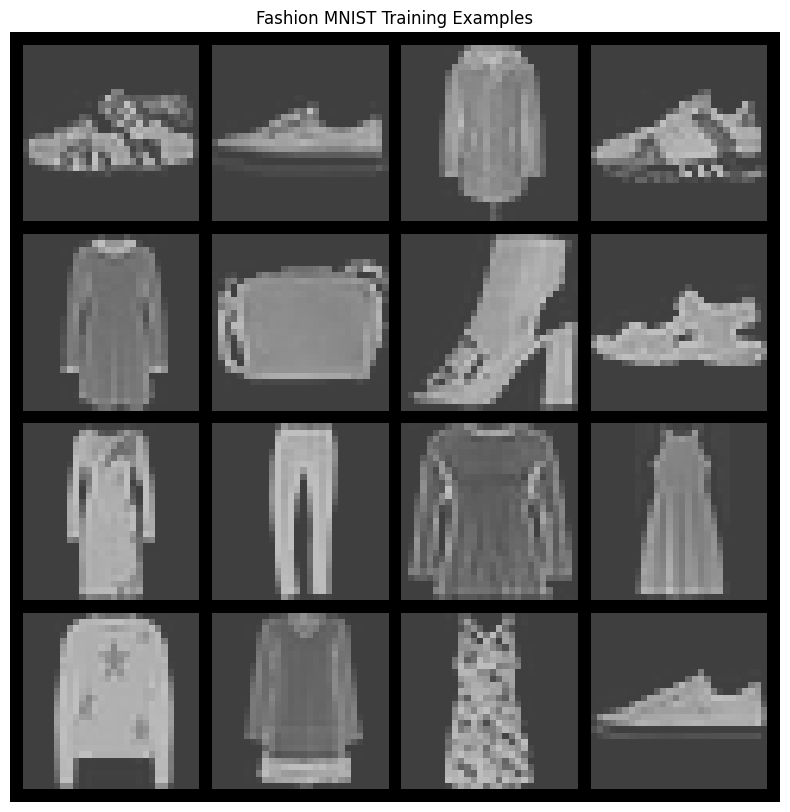

In [ ]:

# Visualize some examples
def show_images(images, title="", labels=None):
    """Display a batch of images."""
    plt.figure(figsize=(10, 10))

    # Unnormalize the images
    images = (images + 1) / 2

    # Create a grid of images
    grid = make_grid(images[:16], nrow=4).permute(1, 2, 0)
    plt.imshow(grid.cpu().numpy(), cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
# Display some training examples
dataiter = iter(train_loader)
images, labels = next(dataiter)
show_images(images, "Fashion MNIST Training Examples", labels)


In [ ]:
# ---------------------------------------------------
# Part 3: Define the DDPM Noise Schedule
# ---------------------------------------------------

def ddpm_schedules(beta1: float, beta2: float, T: int, device: str = 'cpu') -> dict:
    """
    Returns pre-computed schedules for DDPM sampling, training process.

    Args:
        beta1: Start value for the noise schedule
        beta2: End value for the noise schedule
        T: Number of diffusion steps

    Returns:
        A dictionary of useful values for the diffusion process
    """
    # Noise schedule
    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32, device=device) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)

    # Alpha schedule
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    # Other useful quantities
    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab = (1 - alpha_t) / sqrtmab

    return {
        "beta_t": beta_t,  # β_t
        "alpha_t": alpha_t,  # α_t
        "oneover_sqrta": oneover_sqrta,  # 1/√α_t
        "sqrt_beta_t": sqrt_beta_t,  # √β_t
        "alphabar_t": alphabar_t,  # ᾱ_t
        "sqrtab": sqrtab,  # √ᾱ_t
        "sqrtmab": sqrtmab,  # √(1-ᾱ_t)
        "mab_over_sqrtmab": mab_over_sqrtmab,  # (1-α_t)/√(1-ᾱ_t)
    }

Noise schedule computed successfully!


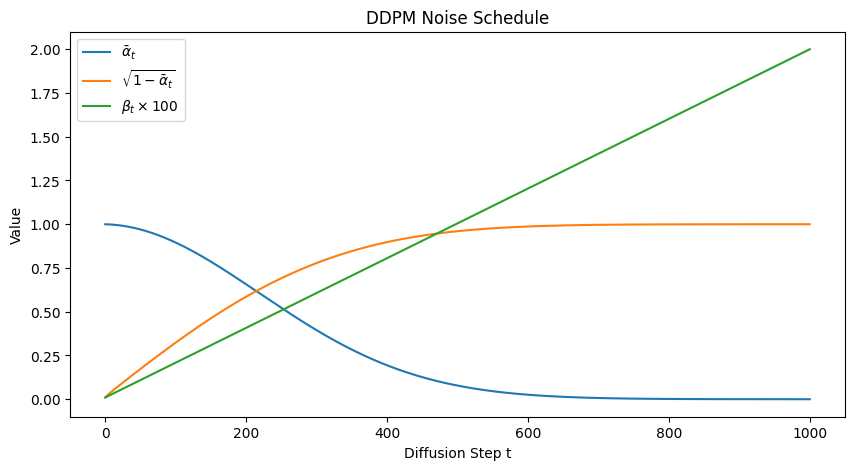

In [ ]:
# Test our implementation
test_schedules = ddpm_schedules(1e-4, 0.02, 1000, device=device)
print("Noise schedule computed successfully!")

# Plot the noise schedule to visualize it
plt.figure(figsize=(10, 5))
plt.plot(test_schedules["alphabar_t"].cpu().numpy(), label=r'$\bar{\alpha}_t$')
plt.plot(test_schedules["sqrtmab"].cpu().numpy(), label=r'$\sqrt{1-\bar{\alpha}_t}$')
plt.plot(test_schedules["beta_t"].cpu().numpy() * 100, label=r'$\beta_t \times 100$')
plt.legend()
plt.title("DDPM Noise Schedule")
plt.xlabel("Diffusion Step t")
plt.ylabel("Value")
plt.show()


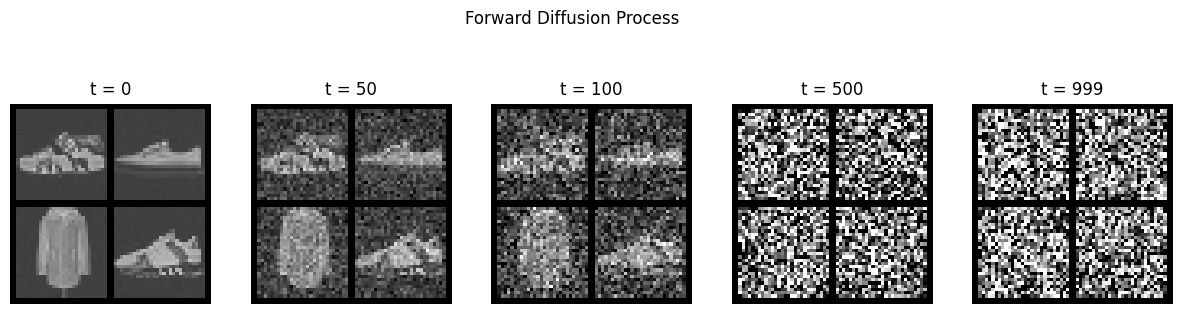

In [ ]:
# ---------------------------------------------------
# Part 4: Implement the Forward Diffusion Process
# ---------------------------------------------------

def forward_diffusion(x0, t, schedules):
    """
    Forward diffusion process: q(x_t | x_0)
    Gradually adds noise to an image according to the noise schedule.

    Args:
        x0: Initial image (clean)
        t: Timestep(s) for which to add noise
        schedules: Dictionary of pre-computed diffusion values

    Returns:
        x_t: Noisy image at timestep t
        noise: The noise that was added
    """
    # Generate random noise
    noise = torch.randn_like(x0)

    # Add noise according to the schedule
    # x_t = √(ᾱ_t) * x_0 + √(1-ᾱ_t) * ε
    x_t = schedules["sqrtab"][t, None, None, None] * x0 + schedules["sqrtmab"][t, None, None, None] * noise

    return x_t, noise

# Test the forward diffusion process
x0 = images[:4].to(device)  # Use 4 images for testing
timesteps = [0, 50, 100, 500, 999]  # Test at different diffusion steps

plt.figure(figsize=(15, 4))
for i, t in enumerate(timesteps):
    t_tensor = torch.tensor([t], device=device).repeat(x0.shape[0])
    x_t, _ = forward_diffusion(x0, t_tensor, test_schedules)

    # Display the noisy image
    plt.subplot(1, len(timesteps), i+1)
    grid = make_grid((x_t + 1)/2, nrow=2).permute(1, 2, 0)
    plt.imshow(grid.cpu().numpy(), cmap='gray')
    plt.title(f"t = {t}")
    plt.axis('off')
plt.suptitle("Forward Diffusion Process")
plt.show()

In [ ]:
# ---------------------------------------------------
# Part 5: Define the Epsilon Prediction Model
# ---------------------------------------------------

# Define a simple convolutional block
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU()
    )

# Create a simpler model for faster training
class UNet(nn.Module):
    """
    Simplified model that predicts the noise added at each step.
    """
    def __init__(self, n_channels=1):
        super(UNet, self).__init__()

        # Simple convolutional neural network
        self.conv = nn.Sequential(
            conv_block(n_channels, 64),
            conv_block(64, 128),
            conv_block(128, 256),
            conv_block(256, 128),
            conv_block(128, 64),
            nn.Conv2d(64, n_channels, 3, padding=1),
        )

        # Time embedding
        self.time_embed = nn.Sequential(
            nn.Linear(1, 64),
            nn.SiLU(),
            nn.Linear(64, 128),
        )

    def forward(self, x, t):
        # Process the input
        features = self.conv(x)

        # Embed time and broadcast
        t_emb = self.time_embed(t.unsqueeze(-1))
        t_emb = t_emb.unsqueeze(-1).unsqueeze(-1)

        # Combine time embedding with features
        # Just adding a small influence from the time embedding
        return features + 0.1 * t_emb.mean(dim=1, keepdim=True)

# Initialize the model
model = UNet().to(device)
print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")

Model created with 748801 parameters


In [ ]:
# ---------------------------------------------------
# Part 6: Implement the DDPM Training and Sampling
# ---------------------------------------------------

class DDPM(nn.Module):
    """
    Denoising Diffusion Probabilistic Model.
    """
    def __init__(self, eps_model, betas, n_T, criterion=nn.MSELoss()):
        super(DDPM, self).__init__()
        self.eps_model = eps_model
        self.n_T = n_T
        self.criterion = criterion

        # Register noise schedule
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

    def forward(self, x):
        """
        Training forward pass. Equivalent to one step of Algorithm 1 in the DDPM paper.
        """
        # Sample random timesteps (batch_size,)
        t = torch.randint(1, self.n_T + 1, (x.shape[0],), device=x.device)

        # Add noise to the input
        noise = torch.randn_like(x)
        x_t = self.sqrtab[t, None, None, None] * x + self.sqrtmab[t, None, None, None] * noise

        # Predict the noise
        predicted_noise = self.eps_model(x_t, t / self.n_T)

        # Calculate loss
        loss = self.criterion(noise, predicted_noise)

        return loss

    def sample(self, n_sample, size, device, return_intermediate_steps=False):
        """
        Sampling function. Equivalent to Algorithm 2 in the DDPM paper.
        """
        # Start with random noise
        x = torch.randn(n_sample, *size).to(device)
        intermediate_steps = []
        # Iteratively denoise
        for i in tqdm(range(self.n_T, 0, -1), desc="Sampling"):
            # Get the current timestep
            t_norm = i / self.n_T

            # Predict the noise
            predicted_noise = self.eps_model(x, torch.ones(n_sample, device=device) * t_norm)

            # If not the last step, add some noise (stochasticity)
            z = torch.randn_like(x) if i > 1 else 0

            # Update x using the predicted noise and schedules
            x = (
                self.oneover_sqrta[i] * (x - predicted_noise * self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            )
            if return_intermediate_steps:
                intermediate_steps.append(x.clone())
        if return_intermediate_steps:
            return x, intermediate_steps
        return x

Epoch 1/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/60, Loss: 0.079034


Epoch 2/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/60, Loss: 0.050936


Epoch 3/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/60, Loss: 0.046581


Epoch 4/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/60, Loss: 0.043335


Epoch 5/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/60, Loss: 0.041443


Epoch 6/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6/60, Loss: 0.041026


Epoch 7/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7/60, Loss: 0.039544


Epoch 8/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8/60, Loss: 0.039011


Epoch 9/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9/60, Loss: 0.038374


Epoch 10/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10/60, Loss: 0.037745


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

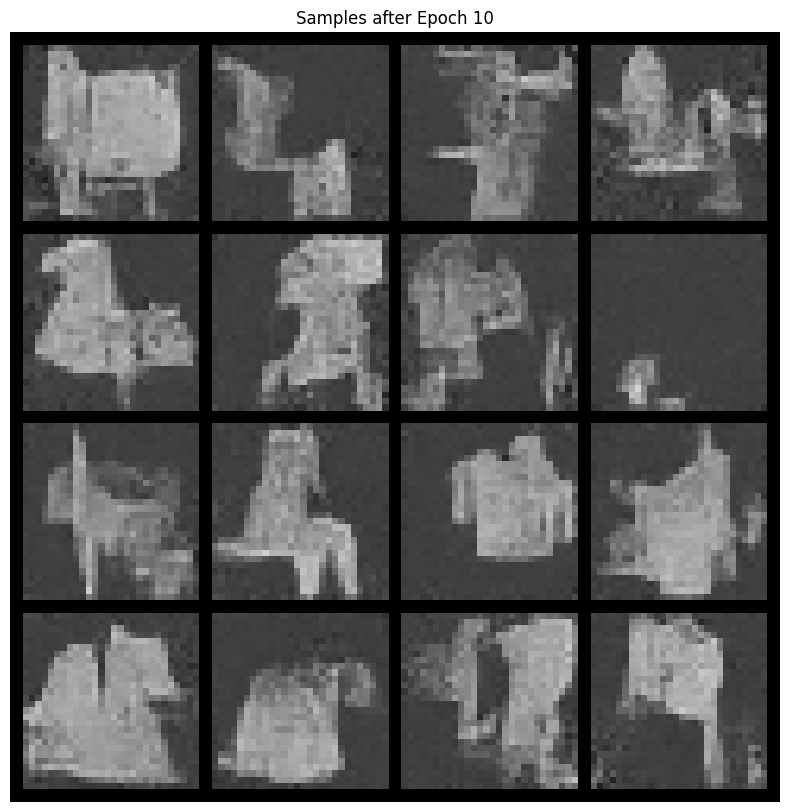

Epoch 11/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 11/60, Loss: 0.037005


Epoch 12/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 12/60, Loss: 0.036999


Epoch 13/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 13/60, Loss: 0.035960


Epoch 14/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 14/60, Loss: 0.036380


Epoch 15/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 15/60, Loss: 0.035846


Epoch 16/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 16/60, Loss: 0.035819


Epoch 17/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 17/60, Loss: 0.035082


Epoch 18/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 18/60, Loss: 0.034988


Epoch 19/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 19/60, Loss: 0.034776


Epoch 20/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 20/60, Loss: 0.034268


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

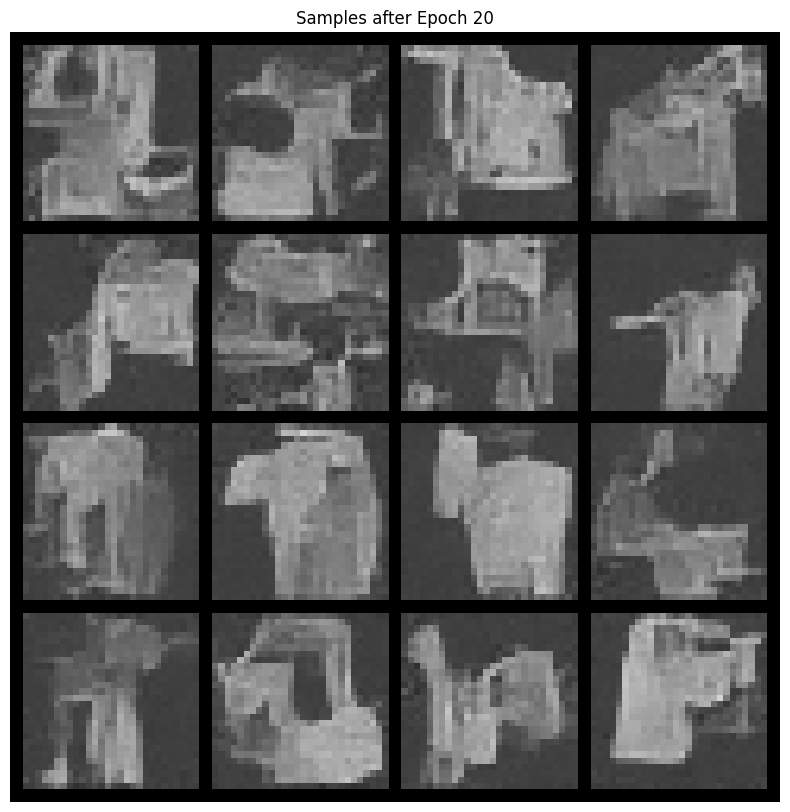

Epoch 21/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 21/60, Loss: 0.034840


Epoch 22/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 22/60, Loss: 0.034714


Epoch 23/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 23/60, Loss: 0.034094


Epoch 24/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 24/60, Loss: 0.033842


Epoch 25/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 25/60, Loss: 0.034115


Epoch 26/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 26/60, Loss: 0.034070


Epoch 27/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 27/60, Loss: 0.034138


Epoch 28/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 28/60, Loss: 0.033782


Epoch 29/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 29/60, Loss: 0.033520


Epoch 30/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 30/60, Loss: 0.033552


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

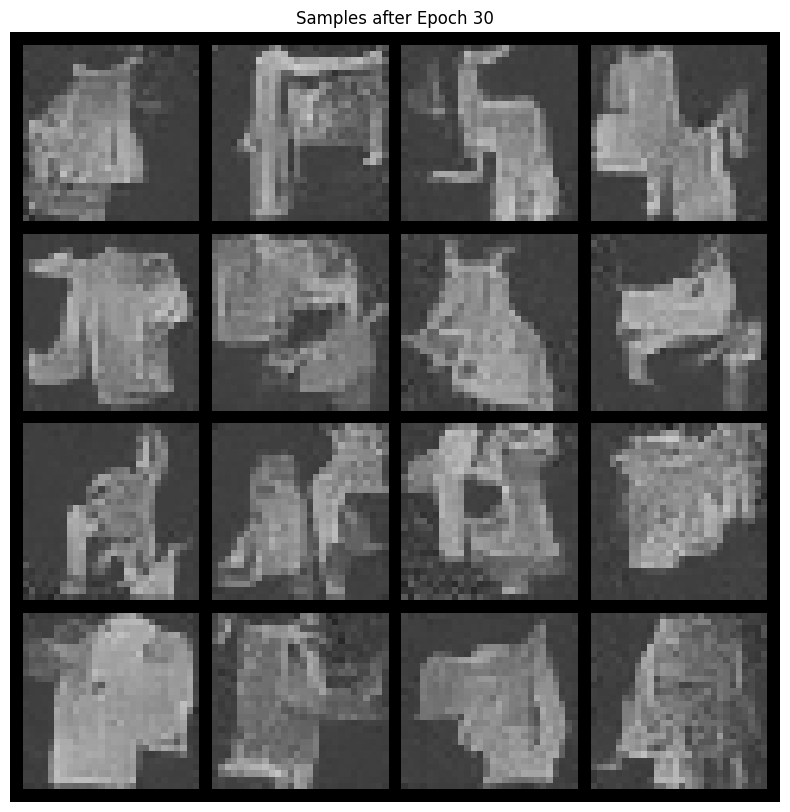

Epoch 31/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 31/60, Loss: 0.033428


Epoch 32/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 32/60, Loss: 0.033196


Epoch 33/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 33/60, Loss: 0.033305


Epoch 34/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 34/60, Loss: 0.032920


Epoch 35/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 35/60, Loss: 0.032984


Epoch 36/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 36/60, Loss: 0.032917


Epoch 37/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 37/60, Loss: 0.033373


Epoch 38/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 38/60, Loss: 0.032689


Epoch 39/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 39/60, Loss: 0.032736


Epoch 40/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 40/60, Loss: 0.032126


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

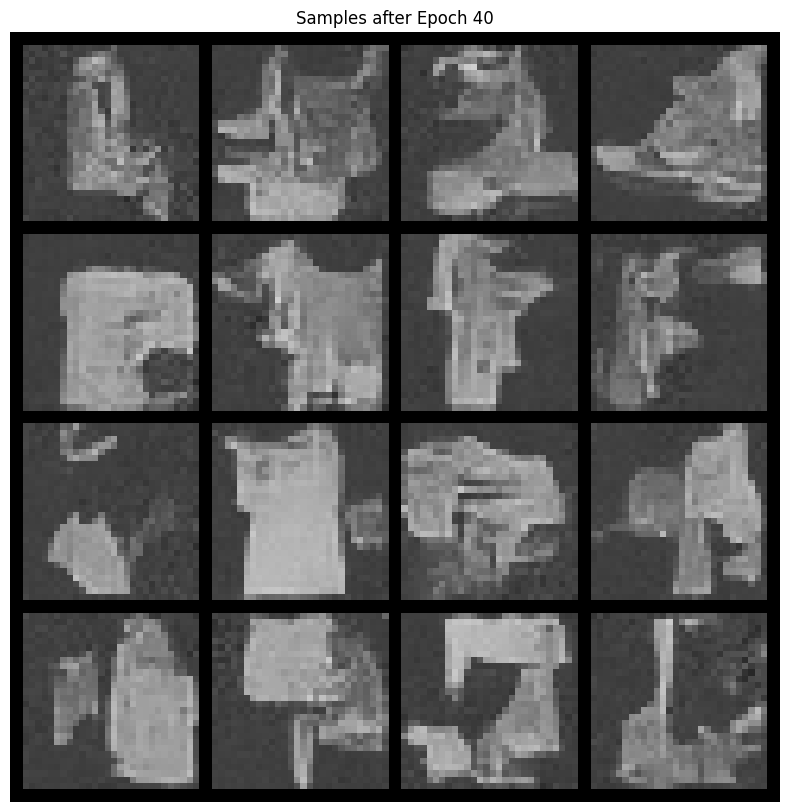

Epoch 41/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 41/60, Loss: 0.032209


Epoch 42/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 42/60, Loss: 0.032721


Epoch 43/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 43/60, Loss: 0.032835


Epoch 44/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 44/60, Loss: 0.032783


Epoch 45/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 45/60, Loss: 0.032145


Epoch 46/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 46/60, Loss: 0.032823


Epoch 47/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 47/60, Loss: 0.032677


Epoch 48/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 48/60, Loss: 0.032352


Epoch 49/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 49/60, Loss: 0.032160


Epoch 50/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 50/60, Loss: 0.032423


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

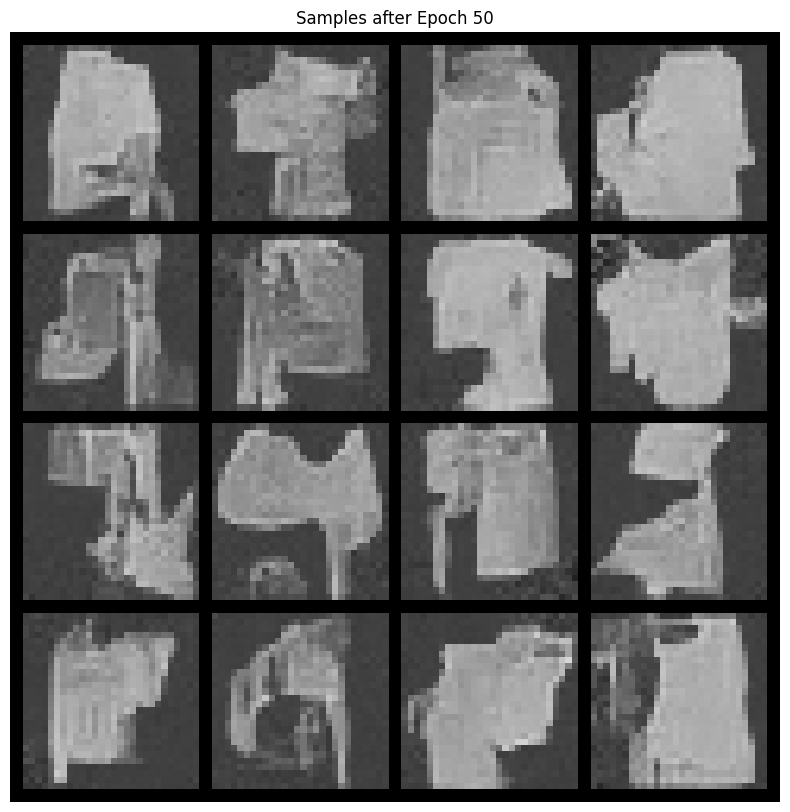

Epoch 51/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 51/60, Loss: 0.032035


Epoch 52/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 52/60, Loss: 0.031548


Epoch 53/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 53/60, Loss: 0.031421


Epoch 54/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 54/60, Loss: 0.032418


Epoch 55/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 55/60, Loss: 0.032031


Epoch 56/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 56/60, Loss: 0.032409


Epoch 57/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 57/60, Loss: 0.032267


Epoch 58/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 58/60, Loss: 0.031631


Epoch 59/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 59/60, Loss: 0.032111


Epoch 60/60:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 60/60, Loss: 0.032044


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

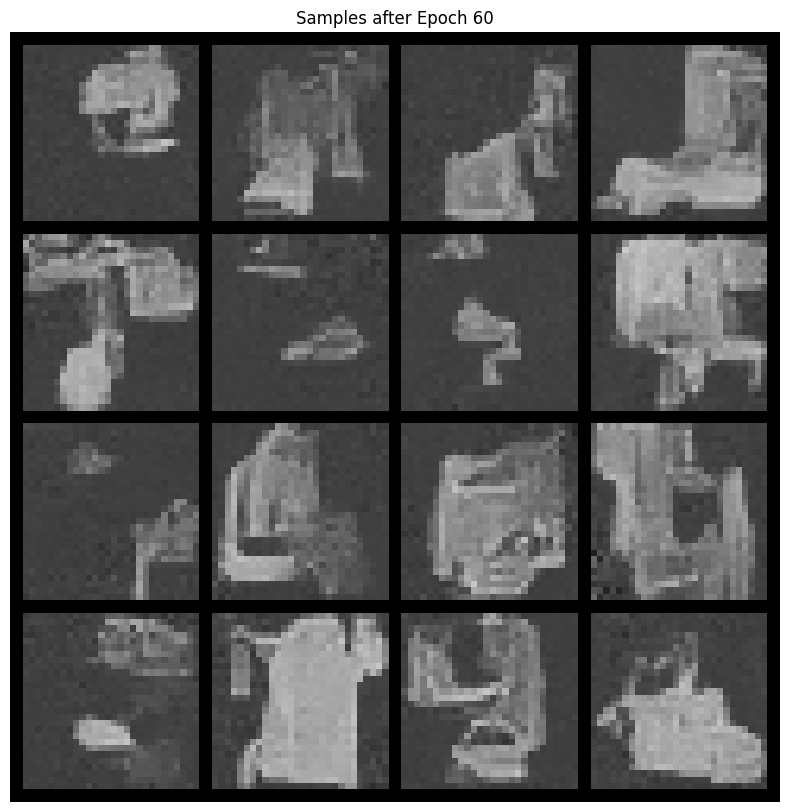

In [ ]:
# ---------------------------------------------------
# Part 7: Train and Sample from the DDPM
# ---------------------------------------------------
# Initialize the DDPM model
ddpm = DDPM(
    eps_model=model,
    betas=(1e-4, 0.02),  # Start and end values for the noise schedule
    n_T=1000,           # Number of diffusion steps
).to(device)

# Optimizer
optimizer = torch.optim.Adam(ddpm.parameters(), lr=1e-4)

# Train the model (only a few epochs for the challenge)
def train_ddpm(model, dataloader, optimizer, n_epochs=10, plot_every=-1):
    """Train the DDPM model."""
    model.train()
    for epoch in range(n_epochs):
        # Use tqdm for a progress bar
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{n_epochs}")
        epoch_loss = 0

        for batch, _ in pbar:
            batch = batch.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            loss = model(batch)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Update progress bar
            epoch_loss += loss.item()
            pbar.set_postfix(loss=loss.item())

        # Print epoch loss
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss/len(dataloader):.6f}")

        # Generate samples
        if plot_every > 0 and (epoch+1) % plot_every == 0:  # Generate samples every 2 epochs
            model.eval()
            with torch.no_grad():
                samples = model.sample(16, (1, 28, 28), device)
                show_images(samples, f"Samples after Epoch {epoch+1}")
            model.train()
train_ddpm(ddpm, train_loader, optimizer, n_epochs=60, plot_every=10)


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

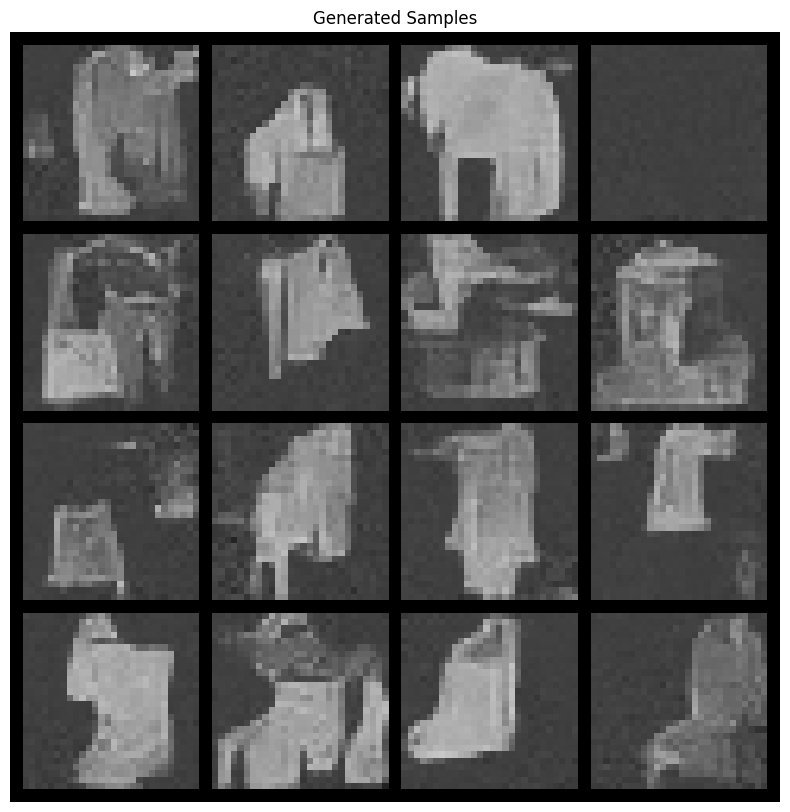

In [ ]:
# ---------------------------------------------------
# Part 8: Evaluate Your Model
# ---------------------------------------------------

def generate_samples(model, n_samples=16):
    """Generate new samples from the trained model."""
    model.eval()
    with torch.no_grad():
        samples, intermediate_steps = model.sample(n_samples, (1, 28, 28), device, return_intermediate_steps=True)
    return samples, intermediate_steps

samples, intermediate_steps = generate_samples(ddpm)
show_images(samples, "Generated Samples")


In [ ]:
def create_batch_slider(intermediate_steps, labels_list=None):
    """
    Create an interactive slider widget to browse through batches of images
    using the existing show_images function.

    Parameters:
    -----------
    intermediate_steps : list
        List of tensors, where each tensor contains a batch of images
    labels_list : list, optional
        List of label tensors corresponding to each batch of images

    Returns:
    --------
    None (displays the widget in the notebook)
    """
    import ipywidgets as widgets
    from IPython.display import display
    from IPython.display import clear_output

    # Create output area for displaying images
    output = widgets.Output()

    # Create slider widget for batch selection
    batch_slider = widgets.IntSlider(
        min=0,
        max=len(intermediate_steps)-1,
        step=1,
        value=len(intermediate_steps)-1,
        description='Denoising step:',
        continuous_update=False,
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='500px')
    )

    # Function to display a batch using the existing show_images function
    def display_batch(step):
        with output:
            clear_output(wait=True)

            # Get current batch of images
            images = intermediate_steps[step]

            # Get corresponding labels if available
            labels = None
            if labels_list is not None and step < len(labels_list):
                labels = labels_list[step]

            # Call the existing show_images function
            show_images(images, title=f"Denoising Step {step + 1}/{len(intermediate_steps)}", labels=labels)

    # Update display when slider value changes
    def on_batch_change(change):
        display_batch(change['new'])

    batch_slider.observe(on_batch_change, names='value')

    # Show initial batch
    display_batch(batch_slider.value)

    # Add play button for slideshow
    play = widgets.Play(
        min=0,
        max=len(intermediate_steps)-1,
        step=10,
        value=len(intermediate_steps)-1,
        interval=1000,  # milliseconds between each frame
        description="Play",
        disabled=False
    )

    # Link play button with slider
    widgets.jslink((play, 'value'), (batch_slider, 'value'))

    # Create horizontal box with play button and slider
    controls = widgets.HBox([play, batch_slider])

    # Display controls and output
    display(widgets.VBox([controls, output]))


In [ ]:
create_batch_slider(intermediate_steps)

# ---------------------------------------------------
# Part 9: Quiz
# ---------------------------------------------------

1. What is the primary difference between GANs and Diffusion Models?

SOLUTION: GANs use a generator and discriminator that are trained adversarially, where the generator tries to produce realistic samples to fool the discriminator. Diffusion models instead gradually add noise to data and then learn to reverse this process through denoising steps. GANs are often faster for sampling but can suffer from mode collapse and training instability, while diffusion models are more stable to train but typically require many steps for sampling.

2. In the forward diffusion process, what happens to the image as t increases?

SOLUTION: As t increases during the forward diffusion process, the image becomes progressively noisier. The original content of the image gradually disappears and is replaced by random Gaussian noise. At t=T (the final step), the image is effectively pure noise with almost no trace of the original image information.

3. What does the UNet model learn to predict in a DDPM?

SOLUTION: The UNet model in a DDPM learns to predict the noise (ε) that was added to the image at a particular timestep. By learning to predict this noise component, the model can then remove it during the reverse diffusion process to gradually recover the clean image. This "noise prediction" approach has been shown to be more stable than directly predicting the clean image.

4. Why do we use a schedule for beta values rather than a constant value?

SOLUTION: We use a schedule for beta values (typically linearly or quadratically increasing) to control the noise addition process more precisely. A gradual schedule allows the model to learn denoising at different noise levels - starting with small noise perturbations and gradually handling larger noise. This makes training more stable and allows the model to effectively learn the entire denoising process from almost-clean to very noisy images.

5. How does the sampling (reverse diffusion) process generate a new image?

SOLUTION: The sampling process starts with pure Gaussian noise (x_T) and iteratively applies the trained denoising model to remove noise step by step. At each step t, the model predicts the noise component in the current noisy image, then uses this prediction to compute a slightly less noisy image for step t-1. The process continues for T steps until we reach x_0, which should be a clean image sample from the learned data distribution.

6. What's the significance of the parameter T (number of timesteps) in diffusion models?

SOLUTION: The parameter T determines the number of diffusion steps in both the forward and reverse processes. A larger T means smaller noise additions at each step, making the diffusion process more gradual and potentially easier for the model to learn. However, larger T values also increase the computational cost and time required for sampling. There's a trade-off between quality (larger T) and sampling speed (smaller T).


<h1>Congratulations! You've completed the DDPM Challenge!</h1>